In [1]:
from netCDF4 import Dataset
from parcels import plotTrajectoriesFile,ParticleSet,JITParticle,FieldSet
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib import colors as c
from datetime import datetime, timedelta
from matplotlib.patches import Polygon
from tqdm.autonotebook import tqdm
import xarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import LogFormatter,LogLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib

/Users/jakecunningham/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
xarray.open_dataset('/Volumes/4YP/Data/Trajectories/Global_Total.nc')

<xarray.Dataset>
Dimensions:     (obs: 2374, traj: 35145)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) int32 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    Age         (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        1.1.1
    parcels_mesh:           spherical

In [3]:
def BasinShaper(finalLon,finalLat,firstLon,firstLat):
#def BasinShaper(firstLon,firstLat,finalLon,finalLat):
    lonGrid=np.linspace(-180,179,360)
    latGrid=np.linspace(-90,90,181)
    identifier=np.zeros((len(latGrid),len(lonGrid)))
    for i in range(len(lon)):
        if 0<finalLat[i]<50:
            #so, first north Atlantic
            if -80<finalLon[i]<30:
                Endspot=7
            if -100<finalLon[i]<-80:
                if finalLat[i]>10:
                    Endspot=7
                else:
                    Endspot=5
            #North Pacific
            if -100>finalLon[i]>-180:
                Endspot=5
            if 180>finalLon[i]>100:
                Endspot=5
            #Indian Ocean
            if 40<finalLon[i]<100:
                Endspot=3
            #Red Sea, which we won't plot
            if 10<finalLat[i]<30:
                if 20<finalLon[i]<43:
                    Endspot=np.nan
        if 50<finalLat[i]<60:
            #North Atlantic
            if -80<finalLon[i]<80:
                Endspot=7
        	#North Pacific
            if -100>finalLon[i]>-180:
                Endspot=5
            if 180>finalLon[i]>100:
                Endspot=5
        if 60<finalLat[i]:
            if -120<finalLon[i]<90:
                Endspot=1 #arctic Ocean
        if -50<finalLat[i]<0:
            #South Atlantic
            if 20>finalLon[i]>-70:
                Endspot=6
            #South Pacific
            if -70>finalLon[i]>-180:
                Endspot=4
            if 180>finalLon[i]>150:
                Endspot=4
            #indian Ocean
            if 150>finalLon[i]>20:
                Endspot=3
            #southern ocean
        if finalLat[i]<-50:
            Endspot=2
        identifier[np.argmin(np.abs(firstLat[i]-latGrid)),np.argmin(np.abs(firstLon[i]-lonGrid))]=Endspot
    LonG,LatG=np.meshgrid(lonGrid,latGrid)
    identifier[identifier==0]=np.nan
    return [identifier,LonG,LatG]

In [4]:
def draw_screen_poly( lats, lons, m):
    x, y = m( lons, lats )
    xy = zip(x,y)
    xy = np.transpose(np.stack((x,y)))
    poly = Polygon( xy, edgecolor='black', linewidth=2,facecolor='none' )
    plt.gca().add_patch(poly)

In [5]:
File=['/Volumes/4YP/Data/Trajectories/Global_Total.nc',
      '/Volumes/4YP/Data/Trajectories/Global_Total_Stokes.nc',
      '/Volumes/4YP/Data/Trajectories/Global_Total_Stokes_Eulerian_Test.nc',
      '/Volumes/4YP/Data/Trajectories/Global_Total_Stokes_Eulerian_NEW.nc']

/Users/jakecunningham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/Users/jakecunningham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/Users/jakecunningham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


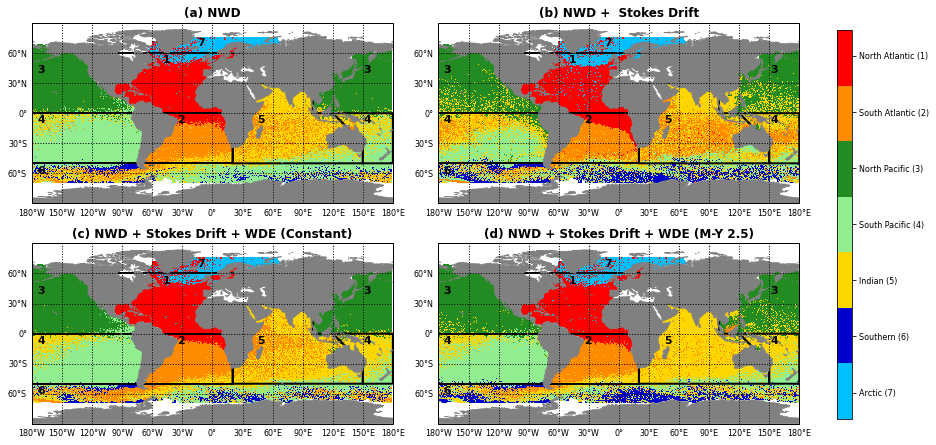

In [7]:
#fig,axes=plt.subplots(nrows=2, ncols=2,figsize=(12,12))
fig = plt.figure(figsize=(12,12))

matplotlib.rc('font', size=8)
matplotlib.rc('axes', titlesize=11)

latCoordBasins=[[0,-50,-50,0],#South Atlantic
                [0,0,-50,-50],#south pacific East
                [-30,0,0,-50,-50,-30],#south pacific West
                [-50,-50,-30,0,0,15,30,30,30],#indian ocean
                [-50,-50],#Southern Ocean
                [60,60]#arctic ocean
                ]
lonCoordBasins=[[20,20,-69,-69],#South Atlantic
                [-69,-180,-180,-69],#south pacific East
                [150,120,180,180,150,150],#south pacific West
                [20,150,150,120,100,100,105,105,20],#indian ocean
                [-180,20],#Southern Ocean
                [-120,90]#arctic ocean
                ]
textlabel=['1','2','3','3','4','4','5','6','7']
lonText=[-50,-35,-175,151,-175,151,45,-175,-15]
latText=[50,-10,40,40,-10,-10,-10,-60,67]
for i in tqdm(range(len(File))):
    dataset=Dataset(File[i])
    lat=dataset.variables['lat'][:]
    lon=dataset.variables['lon'][:]
    lon[lon>180]-=360
    lon[lon<-180]+=360
    finalLat,finalLon=lat[:,-1],lon[:,-1]
    finalLon[finalLon>180]-=360
    firstLat,firstLon=lat[:,0],lon[:,0]
    grid,lonG,latG=BasinShaper(finalLon,finalLat,firstLon,firstLat)
    latmin,latmax=-90,90
    lonmin,lonmax=-180,180
    lonmin,lonmax=-180,180
    ax = plt.subplot(4,2,i+1,projection=ccrs.PlateCarree())
    my_map = Basemap(projection='cyl', llcrnrlon=lonmin, 
                      urcrnrlon=lonmax,llcrnrlat=latmin,urcrnrlat=latmax, 
                      resolution='l')
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face',linewidth=0.5, facecolor='gray'))
    my_map.drawmapboundary()
    for j in range(len(latCoordBasins)):
        draw_screen_poly(latCoordBasins[j],lonCoordBasins[j],my_map)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    for k in range(len(lonText)):
        plt.text(lonText[k],latText[k],textlabel[k],fontsize=11,weight='bold')
    #colors=['red','darkorange','forestgreen','lightgreen','gold','cyan']
    colors=['deepskyblue','mediumblue','gold','lightgreen','forestgreen','darkorange','red']
    cmap_c=c.ListedColormap(colors)
    label=['Free','North Atlantic','North Pacific','South Pacific','South Atlantic','Indian Ocean','Southern Ocean','Arctic Ocean']
    basin=my_map.pcolormesh(lonG,latG,grid,cmap=cmap_c)
    title=['(a) NWD','(b) NWD +  Stokes Drift','(c) NWD + Stokes Drift + WDE (Constant)','(d) NWD + Stokes Drift + WDE (M-Y 2.5)']
    plt.title(title[i],fontweight='bold',fontsize=12)
    
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)
    
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.96, 0.52, 0.017, 0.45])
cbar=fig.colorbar(basin,cax=cbar_ax)
cbar.set_ticks(np.linspace(1.4,6.6,7))
cbar.ax.set_yticklabels(['Arctic (7)','Southern (6)', 'Indian (5)', 'South Pacific (4)','North Pacific (3)','South Atlantic (2)','North Atlantic (1)'])

plt.savefig('/Users/jakecunningham/Documents/Summer Research/Figures/Interbasin_Connectivity.png', format='png', dpi=600,bbox_inches = "tight")

/Users/jakecunningham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(4, 2)
(4, 2)
(6, 2)
(9, 2)
(2, 2)
(2, 2)
(4, 2)
(4, 2)
(6, 2)
(9, 2)
(2, 2)
(2, 2)



/Users/jakecunningham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


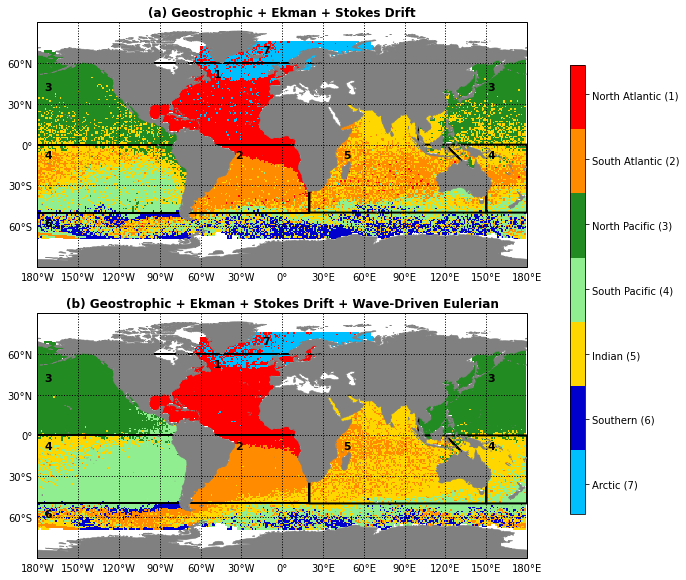

In [13]:
File=['/Volumes/4YP/Data/Trajectories/Global_Total_Stokes.nc','/Volumes/4YP/Data/Trajectories/Global_Total_Stokes_Eulerian.nc']

fig,axes=plt.subplots(nrows=2, ncols=1,figsize=(10,12))
latCoordBasins=[[0,-50,-50,0],#South Atlantic
                [0,0,-50,-50],#south pacific East
                [-30,0,0,-50,-50,-30],#south pacific West
                [-50,-50,-30,0,0,15,30,30,30],#indian ocean
                [-50,-50],#Southern Ocean
                [60,60]#arctic ocean
                ]
lonCoordBasins=[[20,20,-69,-69],#South Atlantic
                [-69,-180,-180,-69],#south pacific East
                [150,120,180,180,150,150],#south pacific West
                [20,150,150,120,100,100,105,105,20],#indian ocean
                [-180,20],#Southern Ocean
                [-120,90]#arctic ocean
                ]
textlabel=['1','2','3','3','4','4','5','6','7']
lonText=[-50,-35,-175,151,-175,151,45,-175,-15]
latText=[50,-10,40,40,-10,-10,-10,-60,67]
for i in tqdm(range(len(File))):
    dataset=Dataset(File[i])
    lat=dataset.variables['lat'][:]
    lon=dataset.variables['lon'][:]
    lon[lon>180]-=360
    lon[lon<-180]+=360
    finalLat,finalLon=lat[:,-1],lon[:,-1]
    finalLon[finalLon>180]-=360
    firstLat,firstLon=lat[:,0],lon[:,0]
    grid,lonG,latG=BasinShaper(finalLon,finalLat,firstLon,firstLat)
    latmin,latmax=-90,90
    lonmin,lonmax=-180,180
    lonmin,lonmax=-180,180
    ax = plt.subplot(3,1,i+1,projection=ccrs.PlateCarree())
    my_map = Basemap(projection='cyl', llcrnrlon=lonmin, 
                      urcrnrlon=lonmax,llcrnrlat=latmin,urcrnrlat=latmax, 
                      resolution='l')
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face',linewidth=0.5, facecolor='gray'))
    my_map.drawmapboundary()
    for j in range(len(latCoordBasins)):
        draw_screen_poly(latCoordBasins[j],lonCoordBasins[j],my_map)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    for k in range(len(lonText)):
        plt.text(lonText[k],latText[k],textlabel[k],fontsize=11,weight='bold')
    #colors=['red','darkorange','forestgreen','lightgreen','gold','cyan']
    colors=['deepskyblue','mediumblue','gold','lightgreen','forestgreen','darkorange','red']
    cmap_c=c.ListedColormap(colors)
    label=['Free','North Atlantic','North Pacific','South Pacific','South Atlantic','Indian Ocean','Southern Ocean','Arctic Ocean']
    basin=my_map.pcolormesh(lonG,latG,grid,cmap=cmap_c)
    title=['(a) Geostrophic + Ekman + Stokes Drift','(b) Geostrophic + Ekman + Stokes Drift + Wave-Driven Eulerian']
    plt.title(title[i],fontweight='bold',fontsize=12)
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.9, 0.4, 0.02, 0.52])
cbar=fig.colorbar(basin,cax=cbar_ax)
cbar.set_ticks(np.linspace(1.4,6.6,7))
cbar.ax.set_yticklabels(['Arctic (7)','Southern (6)', 'Indian (5)', 'South Pacific (4)','North Pacific (3)','South Atlantic (2)','North Atlantic (1)'])

fig.tight_layout(h_pad=3.0)

plt.savefig('/Users/jakecunningham/Documents/4YP/Figures/Poster_Interbasin_Connectivity.png', format='png', dpi=600,bbox_inches = "tight")